In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

Dimensions:  (540, 960, 3)


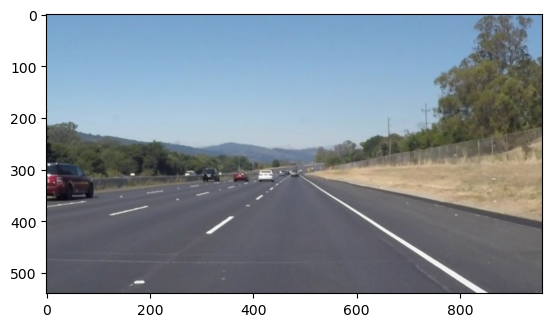

In [4]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')

print('Dimensions: ', img.shape)
plt.imshow(img)

In [13]:
# Convert image to grayscale
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Apply Canny edge detection
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

# Apply Gaussian blur to reduce noise
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Create a masked region of interest
def region_of_interest(img, vertices):
    # Create an empty mask
    mask = np.zeros_like(img)
    
    # Handle both 3-channel and 1-channel images
    if len(img.shape)>2:
        channel_count = img.shape[2]
        ignore_mask_color = (255, )*channel_count
    else:
        ignore_mask_color = 255
        
    # Fill the polygon defined by vertices with the mask color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # Apply the mask to the image
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Draw lane lines on the image
def draw_lines(img, lines, color=[255,0,0], thickness=4):
    # Separate line points for left and right lanes
    x_left_lane = []
    y_left_lane = []
    x_right_lane = []
    y_right_lane = []
    ytop = int(350)  # Top y-coordinate for drawing lines
    ybtm = int(540)  # Bottom y-coordinate for drawing lines
    
    # Categorize lines as left or right based on slope
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = float((y2-y1)/(x2-x1))
            # Positive slope indicates left lane
            if(slope>0.3):
                x_left_lane.append(x1)
                x_left_lane.append(x2)
                y_left_lane.append(y1)
                y_left_lane.append(y2)
            # Negative slope indicates right lane    
            if(slope <-0.3):
                x_right_lane.append(x1)
                x_right_lane.append(x2)
                y_right_lane.append(y1)
                y_right_lane.append(y2)
                
    # Draw lines if points are found for both lanes
    if (x_left_lane!=[]) & (x_right_lane!=[]) & (y_left_lane!=[]) & (y_right_lane!=[]):
        # Fit a line to left lane points
        left_line_coeffs = (np.polyfit(x_left_lane, y_left_lane, 1))
        left_xtop = int((ytop-left_line_coeffs[1])/(left_line_coeffs[0]))
        left_xbtm = int((ybtm-left_line_coeffs[1])/(left_line_coeffs[0]))
        
        cv2.line(img,(left_xtop, ytop), (left_xbtm, ybtm), color, thickness)
        
        # Fit a line to right lane points
        right_line_coeffs = np.polyfit(x_right_lane, y_right_lane, 1)
        right_xtop = int((ytop - right_line_coeffs[1])/right_line_coeffs[0])
        right_xbtm = int((ybtm - right_line_coeffs[1])/right_line_coeffs[0])
       
        cv2.line(img, (right_xtop, ytop), (right_xbtm, ybtm), color, thickness)

# Apply Hough transform to detect lines        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    # Detect lines using Hough transform
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    # Create blank image to draw lines on
    line_img = np.zeros((img.shape[0], img.shape[1],3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Combine the original image with the lane lines image
def weighted_img(img, initial_img, a=0.8, b=1., y=0.):
    return cv2.addWeighted(initial_img, a, img, b, y)



In [14]:
import os
test_images_list = os.listdir('test_images/')

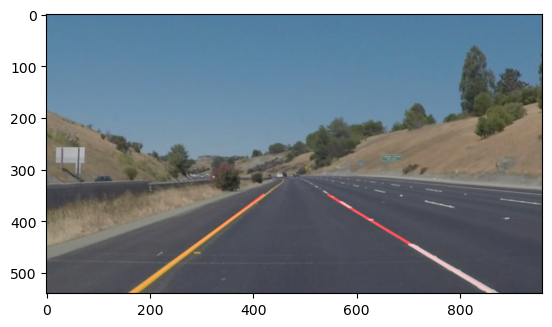

In [21]:
for test_image in test_images_list:
    # Read the test image
    image = mpimg.imread('test_images/solidYellowCurve2.jpg')
    
    # Convert image to grayscale
    gray = grayscale(image)
    
    # Apply Gaussian blur to reduce noise
    blur = gaussian_blur(image, 3)
    
    # Detect edges using Canny edge detection
    edges = canny(blur, 50, 150)
    
    # Create mask of zeros same size as edges image
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    # Defining a four-sided polygon region to mask, using full length of bottom of image and \top verticies are defined to capture lanes in distance
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(390, 350), (580,350), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # Apply region of interest mask
    masked_edges = region_of_interest(edges, vertices)
    # Apply Hough transform to detect lines
    line_image = hough_lines(masked_edges, 2, np.pi/180, 20, 15, 25)
    
    # Combine original image with detected lane lines
    final_img = weighted_img(line_image, image, a=0.8, b=1.)
    
    # Display the result
    plt.imshow(final_img)


In [32]:
def process_image(image):
    # Convert input image to grayscale for edge detection
    gray = grayscale(image)
    
    # Apply Gaussian blur to reduce noise in the image
    blur = gaussian_blur(image, 3)
    
    # Detect edges using Canny edge detection algorithm
    # Parameters: low threshold=50, high threshold=150
    edges = canny(blur, 50, 150)
    
    # Create an empty mask image with same dimensions as edge image
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    # Defining a four-sided polygon region to mask, using full length of bottom of image and 
    # top vertices are defined to capture lanes in distance
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(390, 350), (580,350), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # Apply region of interest mask to focus on road lanes
    masked_edges = region_of_interest(edges, vertices)
    # Apply Hough transform to detect lines in the masked edge image
    # Parameters: rho=2, theta=pi/180, threshold=20, min_line_length=15, max_line_gap=25
    line_image = hough_lines(masked_edges, 2, np.pi/180, 20, 15, 25)
    
    # Combine the original image with detected lane lines
    # Parameters: alpha=0.8 (original image weight), beta=1.0 (line image weight)
    final_img = weighted_img(line_image, image, a=0.8, b=1.)
    
    return final_img

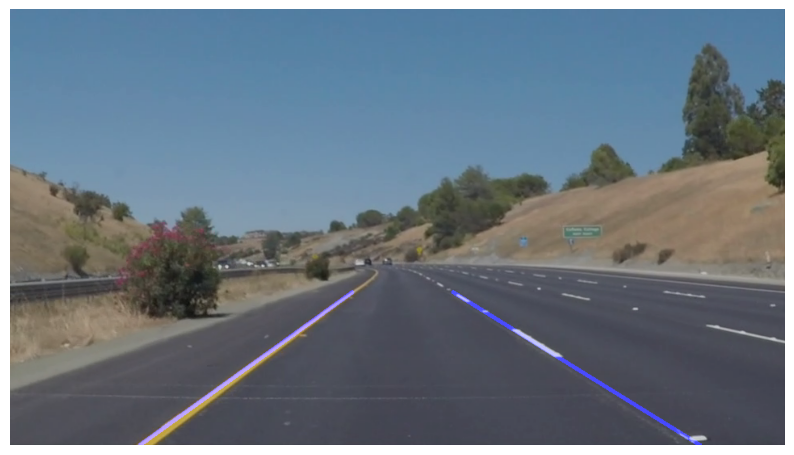

In [37]:
# Import required display modules from IPython and ipywidgets
from IPython.display import display, clear_output
import ipywidgets as widgets

# Create a VideoCapture object to read the video file
cap = cv2.VideoCapture('test_videos/solidYellowLeft.mp4')

# Check if video file was successfully opened
if not cap.isOpened():
    print('Error')
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Create figure for displaying video frames
fig, ax = plt.subplots(figsize=(10,6))

# Process video frame by frame
while cap.isOpened():
    # Read a frame from video
    ret, frame = cap.read()
    if ret:
        # Apply lane detection processing to frame
        processed_frame = process_image(frame)
        
        # Convert processed frame from BGR to RGB color space for display
        processed_frame_rgb = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
        
        # Clear previous frame and display current frame
        ax.clear()
        ax.imshow(processed_frame_rgb)
        ax.axis('off')
        display(fig)
        clear_output(wait=True)
        
        # Add delay between frames based on video fps
        plt.pause(1/fps)
    
    else:
        break

# Release video capture object
cap.release()